### Reduce the number of rows
We re-schedule the Flink events so that they take up four rows instead of eight.

In [37]:
import pandas as pd

In [38]:
df = pd.read_json('timeline.variable.flink.json')
df = df.sort_values(by=['cat', 'tid', 'ts']).reset_index(drop=True)
df['cat'].value_counts()

cat
task::MapBatches(consume)               800
task::ReadRange->MapBatches(produce)    800
Name: count, dtype: int64

In [39]:
categories = {
    'task::ReadRange->MapBatches(produce)': ['CPU:0', 'CPU:1', 'CPU:2', 'CPU:3'],
    'task::MapBatches(consume)': ['CPU:4', 'CPU:5', 'CPU:6', 'CPU:7']
}

def assign_slots(events, num_slots=8):
    events = sorted(events, key=lambda x: x['ts'])
    num_unassigned = 0

    E = [0] * num_slots

    for event in events:
        assigned = False
        slot_idx = [i for i in range(num_slots) if f"CPU:{i}" in categories[event['cat']]]
        for i in slot_idx:
            if E[i] <= event['ts']: 
                E[i] = event['ts'] + event['dur'] 
                event['tid'] = f"CPU:{i}"
                assigned = True
                break
        if not assigned:
            num_unassigned += 1
    
    print(num_unassigned)
    return events


In [41]:
import json
events = assign_slots(json.loads(open('timeline.variable.flink.json').read()))
json.dump(events, open('timeline.variable.flink.assigned.json', 'w'), indent=2)

0


### Visualization
Ref `./long_video_plot.ipynb`

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

FIGRATIO = 2 / 5
FIGWIDTH = 10  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)

plt.rcParams.update(
    {
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
    }
)

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

In [45]:
producer_task_name = "task::ReadRange->MapBatches(produce)"
consumer_task_name = "task::MapBatches(consume)"

def plot_task_timeline(df, ax):
    global_start = 0
    for index, row in df.iterrows():
        if global_start == 0:
            global_start = row.name
            break
    # Populate worker id for y coordinates
    df = df[(df.index - global_start) / 1_000_000 >= 10]
    df = df[(df["cat"] == producer_task_name) | (df["cat"] == consumer_task_name)]
    # df = df.sort_values(by=['cat', 'tid', 'ts']).reset_index(drop=True)
    unique_workers = df["tid"].unique()
    y_coordinates = {worker: index - 1 for index, worker in enumerate(sorted(unique_workers, reverse=True))}

    min_start = 1000
    ax.plot([0, 0], [0, 0])  # Note: for add_patch to work
    for index, row in df.iterrows():
        start_time = (index - global_start) / 1_000_000
        min_start = min(min_start, start_time)
        duration = row["dur"] / 1_000_000
        task_name = row["cat"]
        worker = row["tid"]
        y_coordinate = y_coordinates[worker]

        color_index = 1 if task_name == producer_task_name else 2
        color = COLORS[color_index]

        ax.add_patch(
            plt.Rectangle(
                (start_time - min_start, y_coordinate),
                duration,
                0.5,
                fill=True,
                facecolor=color,
                edgecolor="grey",
                linewidth=0.01,
                zorder=100,
            )
        )

    ax.set_xlabel("Time (s)", fontsize=20)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis="x", labelsize=20)

Text(0.5, 1.0, 'timeline.variable.flink.assigned')

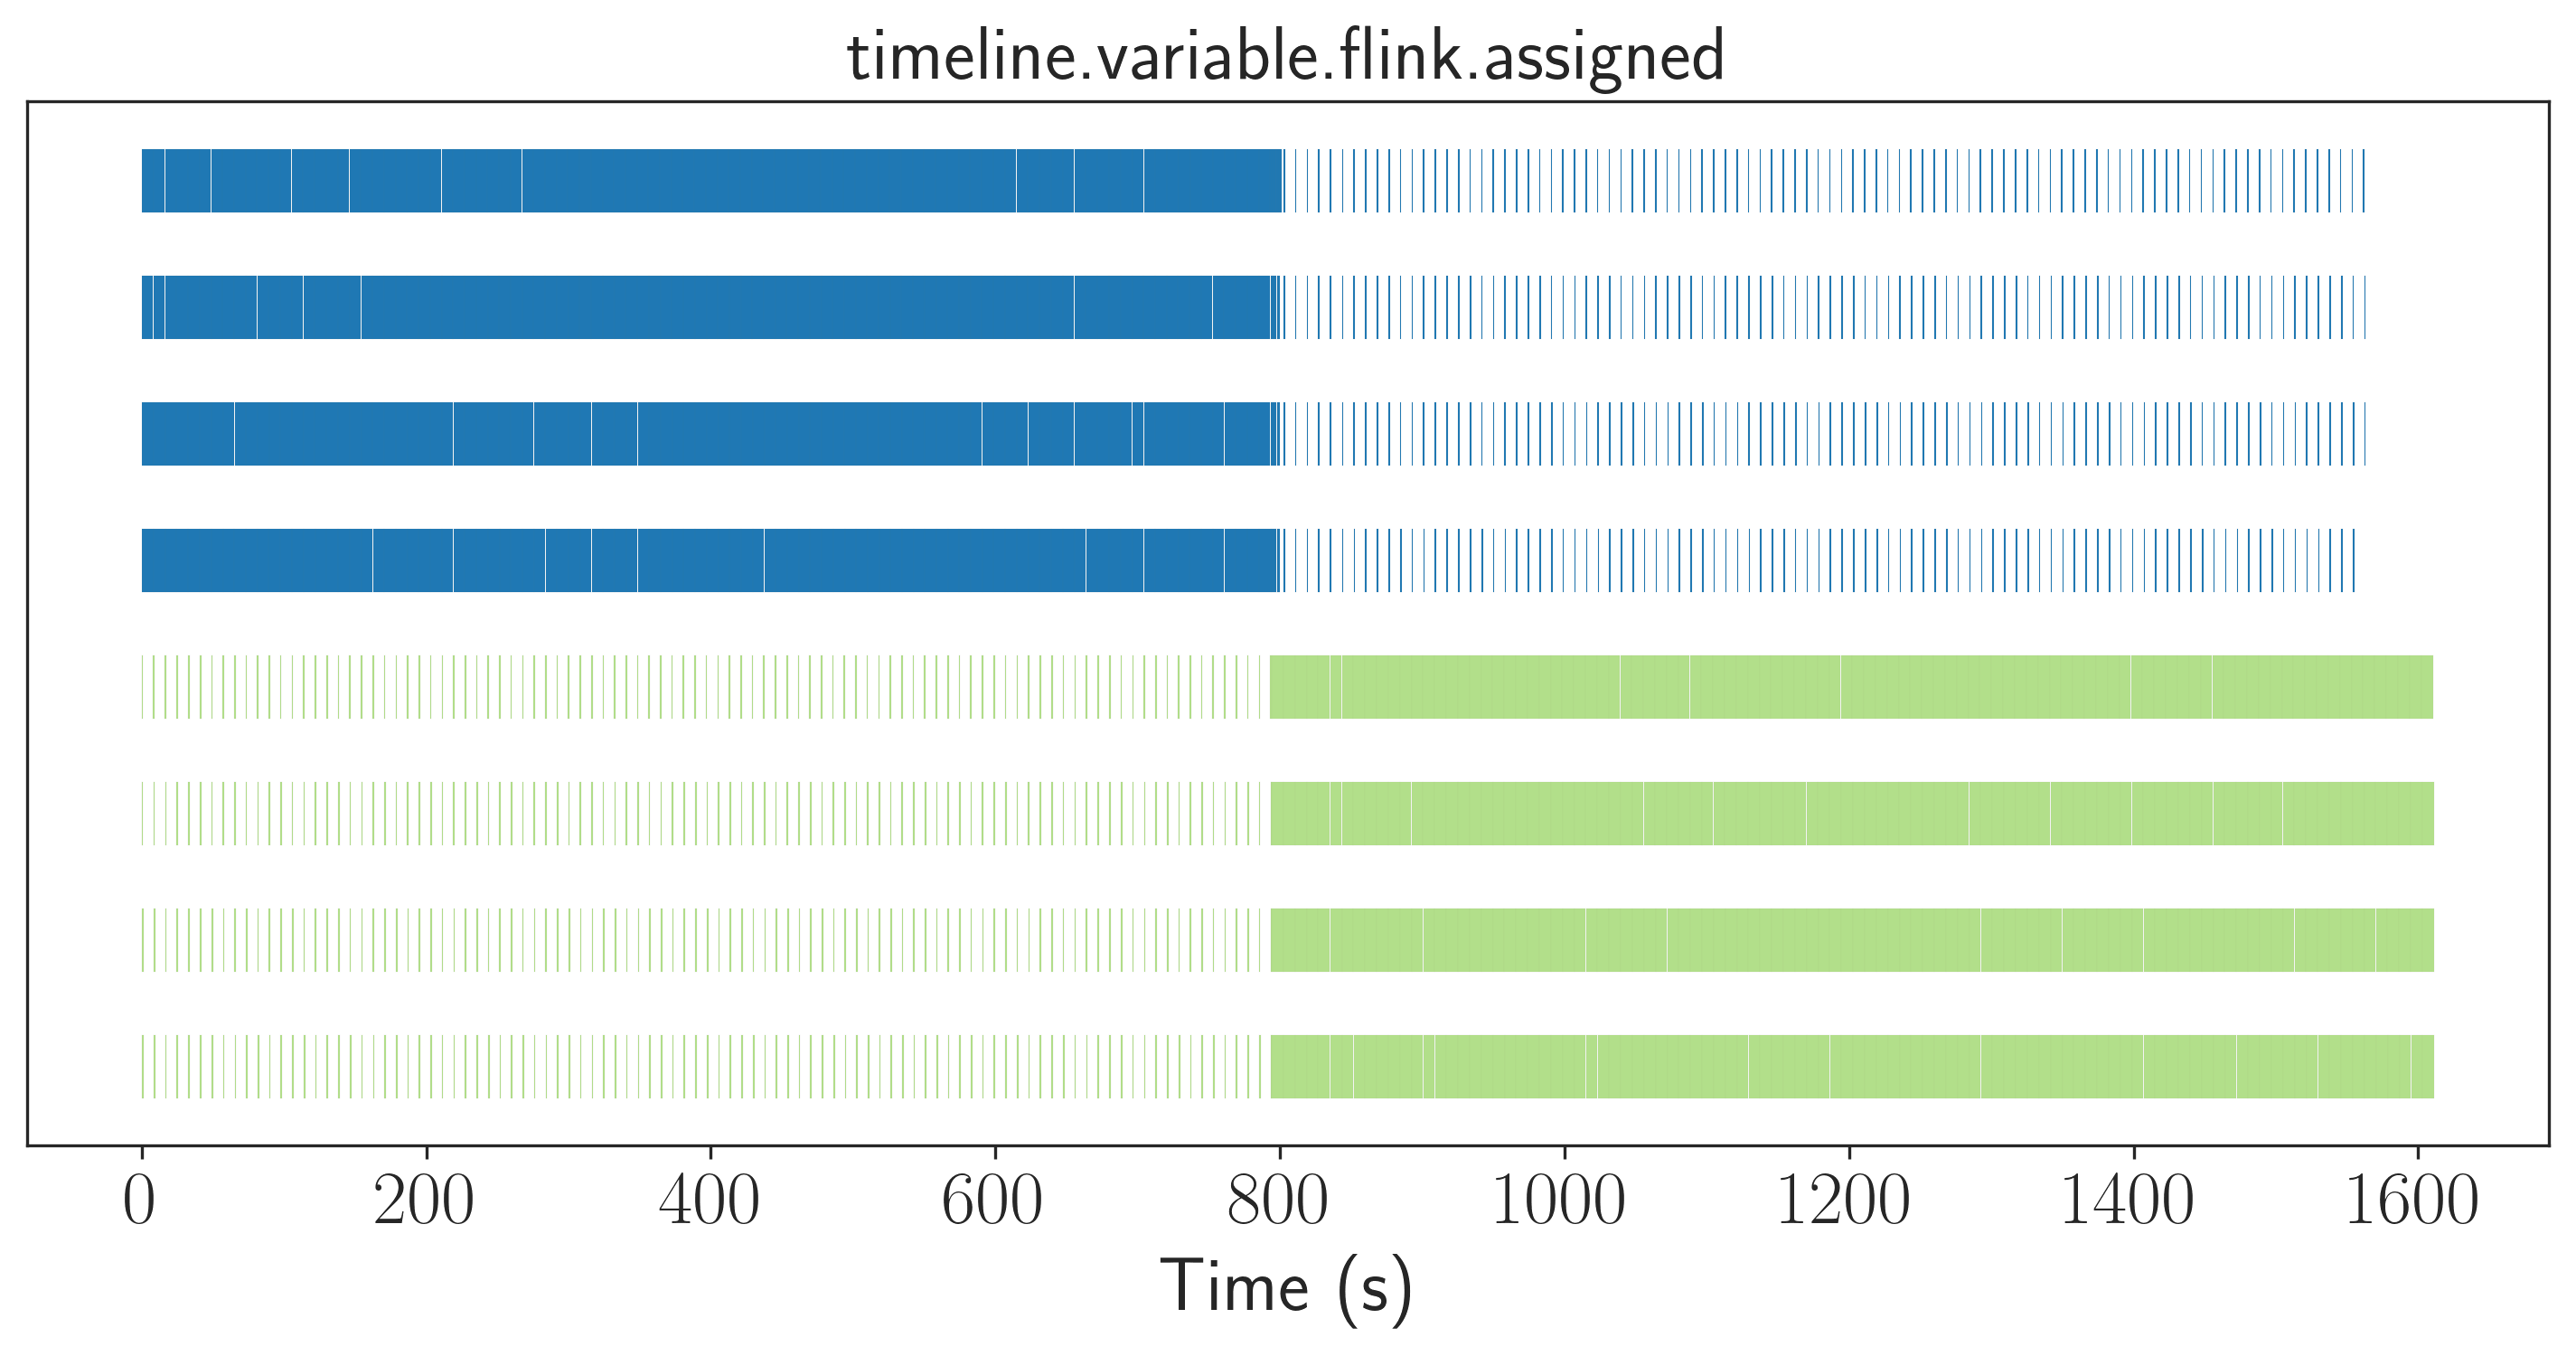

In [46]:
file_path = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/plotting/timeline.variable.flink.assigned.json"

fig, axs = plt.subplots(1, 1, figsize=(12, 5))

df = pd.read_json(file_path)
df.set_index("ts", inplace=True)
df.sort_index(inplace=True)
plot_task_timeline(df, axs)
file_name = os.path.basename(file_path)[:-5]
plot_task_timeline(df, axs)
axs.set_title(file_name, fontsize=20)